Lista2: Klasyfikacja algorytmem k-najbliższych sąsiadów (k-nn)

In [2]:
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
warnings.filterwarnings("ignore", category=FutureWarning, module="scipy")

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from typing import List, Tuple
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
    precision_score,
    accuracy_score,
    recall_score,
    f1_score,
)
from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    train_test_split,
    cross_val_score,
    cross_validate,
    RepeatedKFold,
)

UTILS

In [4]:
def convert_cell(series: pd.Series):
    converted = pd.to_numeric(series, errors="coerce", downcast="float")
    converted = converted.replace([np.inf, -np.inf], np.nan)
    converted = converted.fillna(np.nan)
    return converted


def clear_data(data: pd.DataFrame, target_feature: str):
    classes = data[target_feature]
    columns = data.columns.drop(target_feature)

    df = data[columns].apply(lambda x: convert_cell(x))

    imputer = SimpleImputer(missing_values=np.nan, strategy="median")
    imputed_df = pd.DataFrame(imputer.fit_transform(df), columns=columns)

    return pd.concat([imputed_df, classes], axis=1)


def remove_outliers_lof(data: pd.DataFrame, target_feature: str) -> pd.DataFrame:
    X = data.drop(columns=[target_feature])
    y = data[target_feature]

    lof = LocalOutlierFactor()
    outlier_labels = lof.fit_predict(X)

    inlier_mask = outlier_labels == 1
    X_clean = X.loc[inlier_mask]
    y_clean = y.loc[inlier_mask]

    return pd.concat([X_clean, y_clean], axis=1)


def split_train_test(
    data: pd.DataFrame, target_feature: str, test_size: float = 0.3
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train_data, test_data = train_test_split(
        data,
        test_size=test_size,
        random_state=42,
        stratify=data[target_feature],
    )

    return train_data, test_data


def split_features(
    train_data: pd.DataFrame, test_data: pd.DataFrame, target_feature: str
):
    X_train = train_data[[col for col in train_data.columns if col != target_feature]]
    y_train = train_data[target_feature]
    X_test = test_data[[col for col in test_data.columns if col != target_feature]]
    y_test = test_data[target_feature]

    return X_train, y_train, X_test, y_test


def normalize_features(
    X_train: np.ndarray, X_test: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    X_train_normalized = normalize(X_train)
    X_test_normalized = normalize(X_test)

    return X_train_normalized, X_test_normalized


def scale_numeric_features(
    X_train: np.ndarray, X_test: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled


def apply_pca(
    X_train: np.ndarray, X_test: np.ndarray, components: int = 2
) -> Tuple[np.ndarray, np.ndarray]:
    n_features = X_train.shape[1]
    n_components = min(components, n_features)
    pca = PCA(n_components=n_components)

    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    return X_train_pca, X_test_pca


def predict(
    classifier: KNeighborsClassifier,
    X_Train: np.ndarray,
    X_test: np.ndarray,
    y_train: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray]:
    classifier = classifier
    classifier.fit(X_Train, y_train.squeeze())

    y_pred_train = classifier.predict(X_Train)
    y_pred_test = classifier.predict(X_test)

    return y_pred_train, y_pred_test


def classification_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f_score = f1_score(y_true, y_pred, average="weighted")

    return cm, accuracy, precision, recall, f_score


def plot_confusion_matrix(
    clf: KNeighborsClassifier, X_test: np.ndarray, y_test: np.ndarray
):
    y_pred = clf.predict(X_test)

    print(classification_report(y_test, y_pred, zero_division=0))
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test.squeeze())
    plt.show()


def get_data_for_cross_val(
    data: pd.DataFrame,
    target_feature: str,
    pca_comp: int = 3,
    neighbors: int = 5,
    metric: str = "minkowski",
    weights="uniform",
):
    clean_data = clear_data(data, target_feature)
    no_outliers_data = remove_outliers_lof(clean_data, target_feature)
    X, y, dummy, _ = split_features(no_outliers_data, no_outliers_data, target_feature)
    X_normalized, _ = normalize_features(X, dummy)
    X_scaled, _ = scale_numeric_features(X_normalized, dummy)
    X_pca, _ = apply_pca(X_scaled, dummy, pca_comp)

    clf = KNeighborsClassifier(n_neighbors=neighbors, metric=metric, weights=weights)

    return clf, X_pca, y


def cross_validation_scores(
    data: pd.DataFrame,
    target_feature: str,
    pca_comp=3,
    neighbors: int = 5,
    metric: str = "minkowski",
    weights: str = "uniform",
    folds=5,
    stratify: bool = False,
    repeats: int = 1,
    print_result: bool = False,
):
    clf, X_pca, y = get_data_for_cross_val(
        data, target_feature, pca_comp, neighbors, metric, weights
    )

    if stratify:
        kfold = RepeatedStratifiedKFold(n_splits=folds, n_repeats=repeats)
    else:
        kfold = RepeatedKFold(n_splits=folds, n_repeats=repeats)
    cv_scores = cross_val_score(clf, X_pca, y, cv=kfold, scoring="f1_weighted")
    mean_score = cv_scores.mean()

    if print_result:
        strat = "" if stratify else "non_"
        print(
            f"{folds}-fold {strat}stratify cross-validation: F1-score = {mean_score:.4f}"
        )

    return mean_score


def Compute_scores(data: pd.DataFrame, target_feature: str, pca_comp=3):
    clean_data = clear_data(data, target_feature)

    no_outliers_data = remove_outliers_lof(clean_data, target_feature)

    train_data, test_data = split_train_test(no_outliers_data, target_feature)

    X_train, y_train, X_test, y_test = split_features(
        train_data, test_data, target_feature
    )

    X_train_normalized, X_test_normalized = normalize_features(X_train, X_test)

    X_train_scaled, X_test_scaled = scale_numeric_features(
        X_train_normalized, X_test_normalized
    )

    X_train_pca, X_test_pca = apply_pca(X_train_scaled, X_test_scaled, pca_comp)

    clf = KNeighborsClassifier()
    y_pred_train, y_pred_test = predict(clf, X_train_pca, X_test_pca, y_train)

    plot_confusion_matrix(clf, X_test_pca, y_test)

    return classification_metrics(y_test, y_pred_test)


def custom_distance(dist):
    return 1 / np.log(dist + 1.1)


def full_test(data: pd.DataFrame, target_feature: str, pca_comp: int = 3):
    weights = ["uniform", "distance", custom_distance]
    metrics = ["euclidean", "manhattan", "chebyshev", "minkowski"]
    k_neighbors = [x for x in range(1, 16)]
    folds = [2, 5, 10]
    stratifies = [False, True]

    results = []
    for k_neighbor in k_neighbors:
        for metric in metrics:
            for weight in weights:
                for fold in folds:
                    for stratify in stratifies:
                        score = cross_validation_scores(
                            data,
                            target_feature,
                            pca_comp,
                            k_neighbor,
                            metric,
                            weight,
                            fold,
                            stratify,
                        )
                        w = weight if isinstance(weight, str) else "custom"
                        result = {
                            "K": k_neighbor,
                            "Metric": metric,
                            "Weights": w,
                            "Folds": fold,
                            "Stratify": stratify,
                            "Score": score,
                        }
                        results.append(result)

    results_df = pd.DataFrame(results)

    return results_df


def plot_heatmap(data, *args, **kwargs):
    ax = plt.gca()
    heatmap_data = data.pivot_table(values="Score", index="K", columns="Metric")
    sns.heatmap(
        heatmap_data, annot=True, fmt=".4f", cmap="coolwarm", ax=ax, vmin=0.90, vmax=1.0
    )


def plot_results(results_df: pd.DataFrame):
    results_df["Folds_Stratify"] = (
        results_df["Folds"].astype(str) + "_" + results_df["Stratify"].astype(str)
    )
    g = sns.FacetGrid(
        results_df, col="Folds_Stratify", row="Weights", height=4, aspect=1
    )
    g.map_dataframe(plot_heatmap)
    g.set_titles("Weights: {row_name}, Folds_Stratify: {col_name}")
    plt.show()


def get_top_n_scores(results_df: pd.DataFrame, n: int):
    sorted_df = results_df.sort_values(by="Score", ascending=False)
    top_n = sorted_df.head(n)
    return top_n

IRIS

In [7]:
class Iris:
    sepal_length = "sepal-length"
    sepal_width = "sepal-width"
    petal_length = "petal-length"
    petal_width = "petal-width"
    target_feature = "class"

    def get_dataFrame() -> pd.DataFrame:
        data = pd.read_csv(
            "iris.data",
            names=[
                Iris.sepal_length,
                Iris.sepal_width,
                Iris.petal_length,
                Iris.petal_width,
                Iris.target_feature,
            ],
        )

        return data

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       1.00      0.87      0.93        15
 Iris-virginica       0.88      1.00      0.93        14

       accuracy                           0.95        44
      macro avg       0.96      0.96      0.95        44
   weighted avg       0.96      0.95      0.95        44



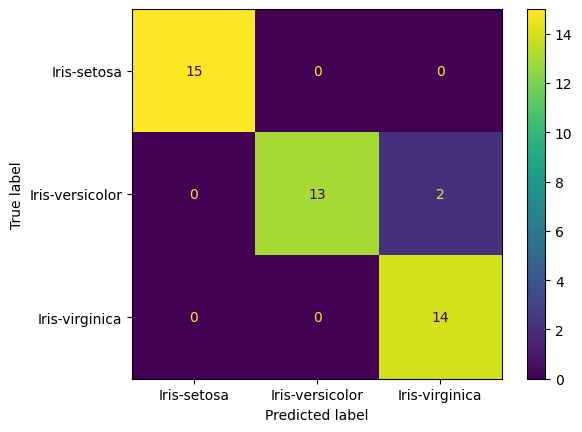

Normal F1: 0.9544
2-fold non_stratify cross-validation: F1-score = 0.9792
5-fold non_stratify cross-validation: F1-score = 0.9727
10-fold non_stratify cross-validation: F1-score = 0.9679


0.9678643578643579

In [8]:
cm, accuracy, precision, recall, f_score = Compute_scores(
    Iris.get_dataFrame(), Iris.target_feature, pca_comp=2
)

print(f"Normal F1: {f_score:.4f}")
cross_validation_scores(
    Iris.get_dataFrame(), Iris.target_feature, pca_comp=2, folds=2, print_result=True
)
cross_validation_scores(
    Iris.get_dataFrame(), Iris.target_feature, pca_comp=2, folds=5, print_result=True
)
cross_validation_scores(
    Iris.get_dataFrame(), Iris.target_feature, pca_comp=2, folds=10, print_result=True
)

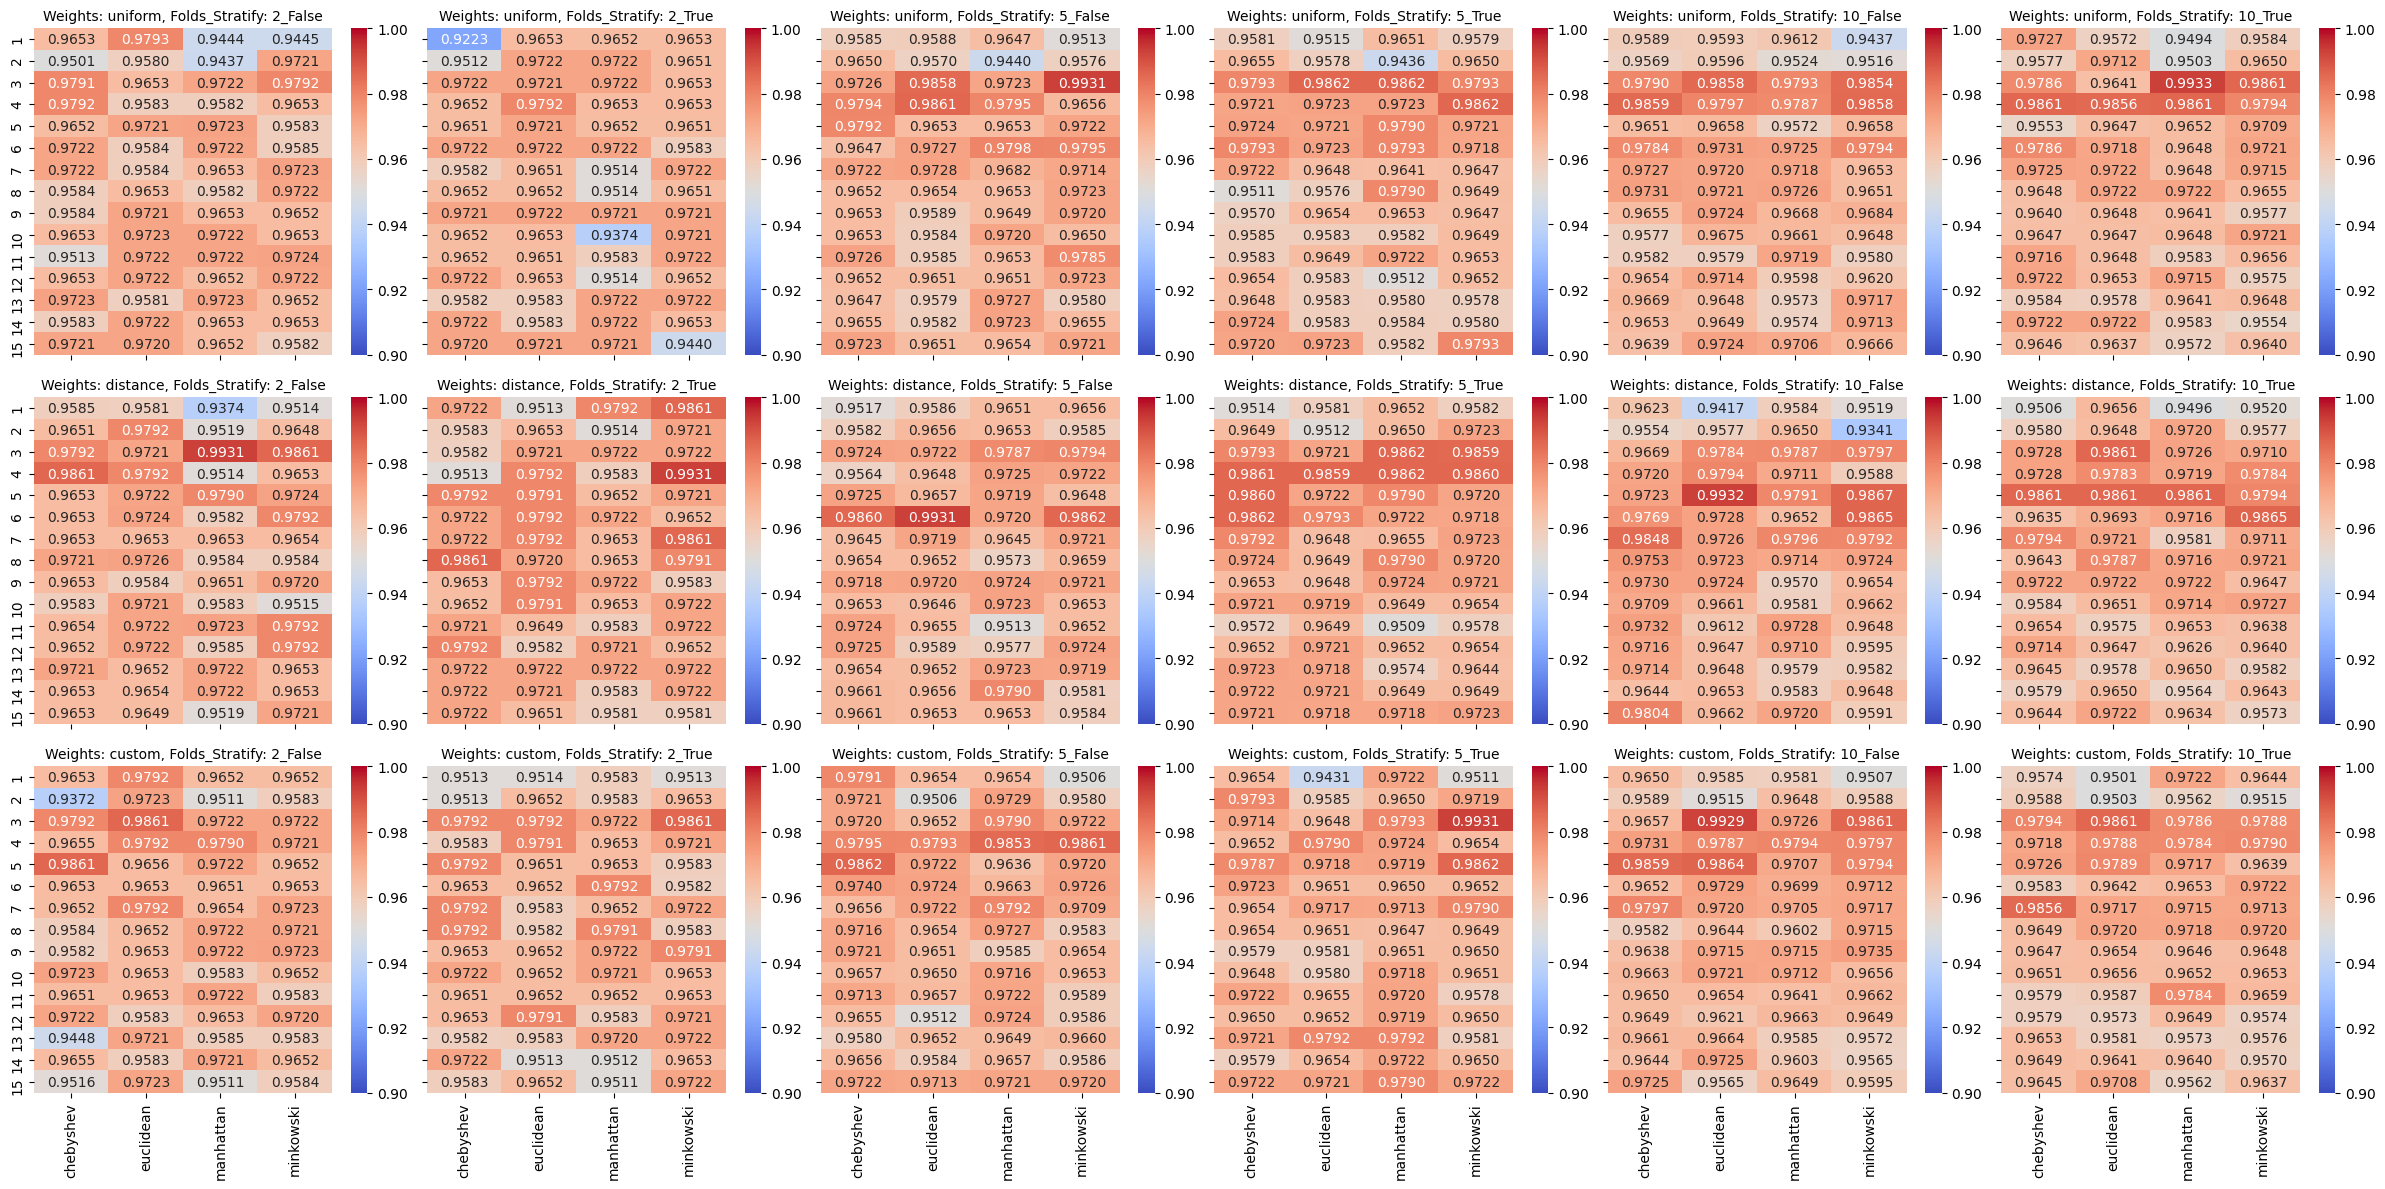

     K     Metric   Weights  Folds  Stratify     Score Folds_Stratify
167  3  manhattan   uniform     10      True  0.993266        10_True
298  5  euclidean  distance     10     False  0.993185       10_False
213  3  minkowski    custom      5      True  0.993103         5_True
168  3  manhattan  distance      2     False  0.993062        2_False
200  3  minkowski   uniform      5     False  0.993060        5_False
277  4  minkowski  distance      2      True  0.993053         2_True
368  6  euclidean  distance      5     False  0.993051        5_False
160  3  euclidean    custom     10     False  0.992929       10_False
352  5  minkowski  distance     10     False  0.986667       10_False
425  6  minkowski  distance     10      True  0.986532        10_True
424  6  minkowski  distance     10     False  0.986500       10_False
304  5  euclidean    custom     10     False  0.986369       10_False
171  3  manhattan  distance      5      True  0.986207         5_True
243  4  manhattan  d

In [13]:
results_df = full_test(Iris.get_dataFrame(), Iris.target_feature, pca_comp=2)

plot_results(results_df)

print(get_top_n_scores(results_df, 15))

W najlepszych wynikach przeważa sposób głosowania po dystansie.

Ciężko określić najlepszą metode miar odległości ale widać że najgorszą dla tego zbioru danych jest metoda Czebyszewa


WINE

In [9]:
class Wine:
    target_feature = "class"

    def get_dataFrame() -> pd.DataFrame:
        data = pd.read_csv(
            "wine.data",
            names=[
                Wine.target_feature,
                "Alcohol",
                "Malic acid",
                "Ash",
                "Alcanity of ash",
                "Magnesium",
                "Total phenols",
                "Flavanoids",
                "Nonflavanoid phenosis",
                "Proanthocyanins",
                "Color intensity",
                "Hue",
                "OD280/OD315 of diluted wine",
                "Proline",
            ],
        )

        return data

              precision    recall  f1-score   support

           1       0.94      0.94      0.94        17
           2       0.95      0.95      0.95        21
           3       1.00      1.00      1.00        14

    accuracy                           0.96        52
   macro avg       0.96      0.96      0.96        52
weighted avg       0.96      0.96      0.96        52



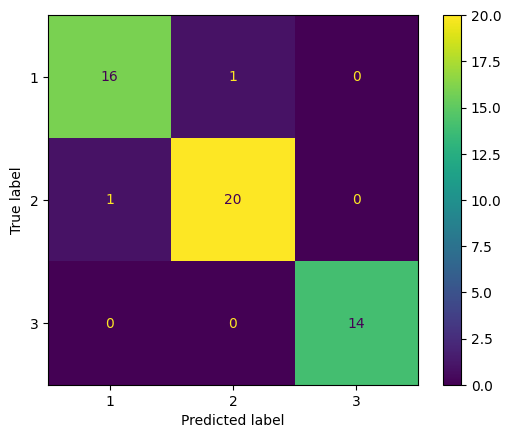

Normal F1: 0.9615
2-fold non_stratify cross-validation: F1-score = 0.9296
5-fold non_stratify cross-validation: F1-score = 0.9357
10-fold non_stratify cross-validation: F1-score = 0.9193


0.9192932420177001

In [10]:
cm, accuracy, precision, recall, f_score = Compute_scores(
    Wine.get_dataFrame(), Wine.target_feature, pca_comp=4
)

print(f"Normal F1: {f_score:.4f}")
cross_validation_scores(
    Wine.get_dataFrame(), Wine.target_feature, pca_comp=4, folds=2, print_result=True
)
cross_validation_scores(
    Wine.get_dataFrame(), Wine.target_feature, pca_comp=4, folds=5, print_result=True
)
cross_validation_scores(
    Wine.get_dataFrame(), Wine.target_feature, pca_comp=4, folds=10, print_result=True
)

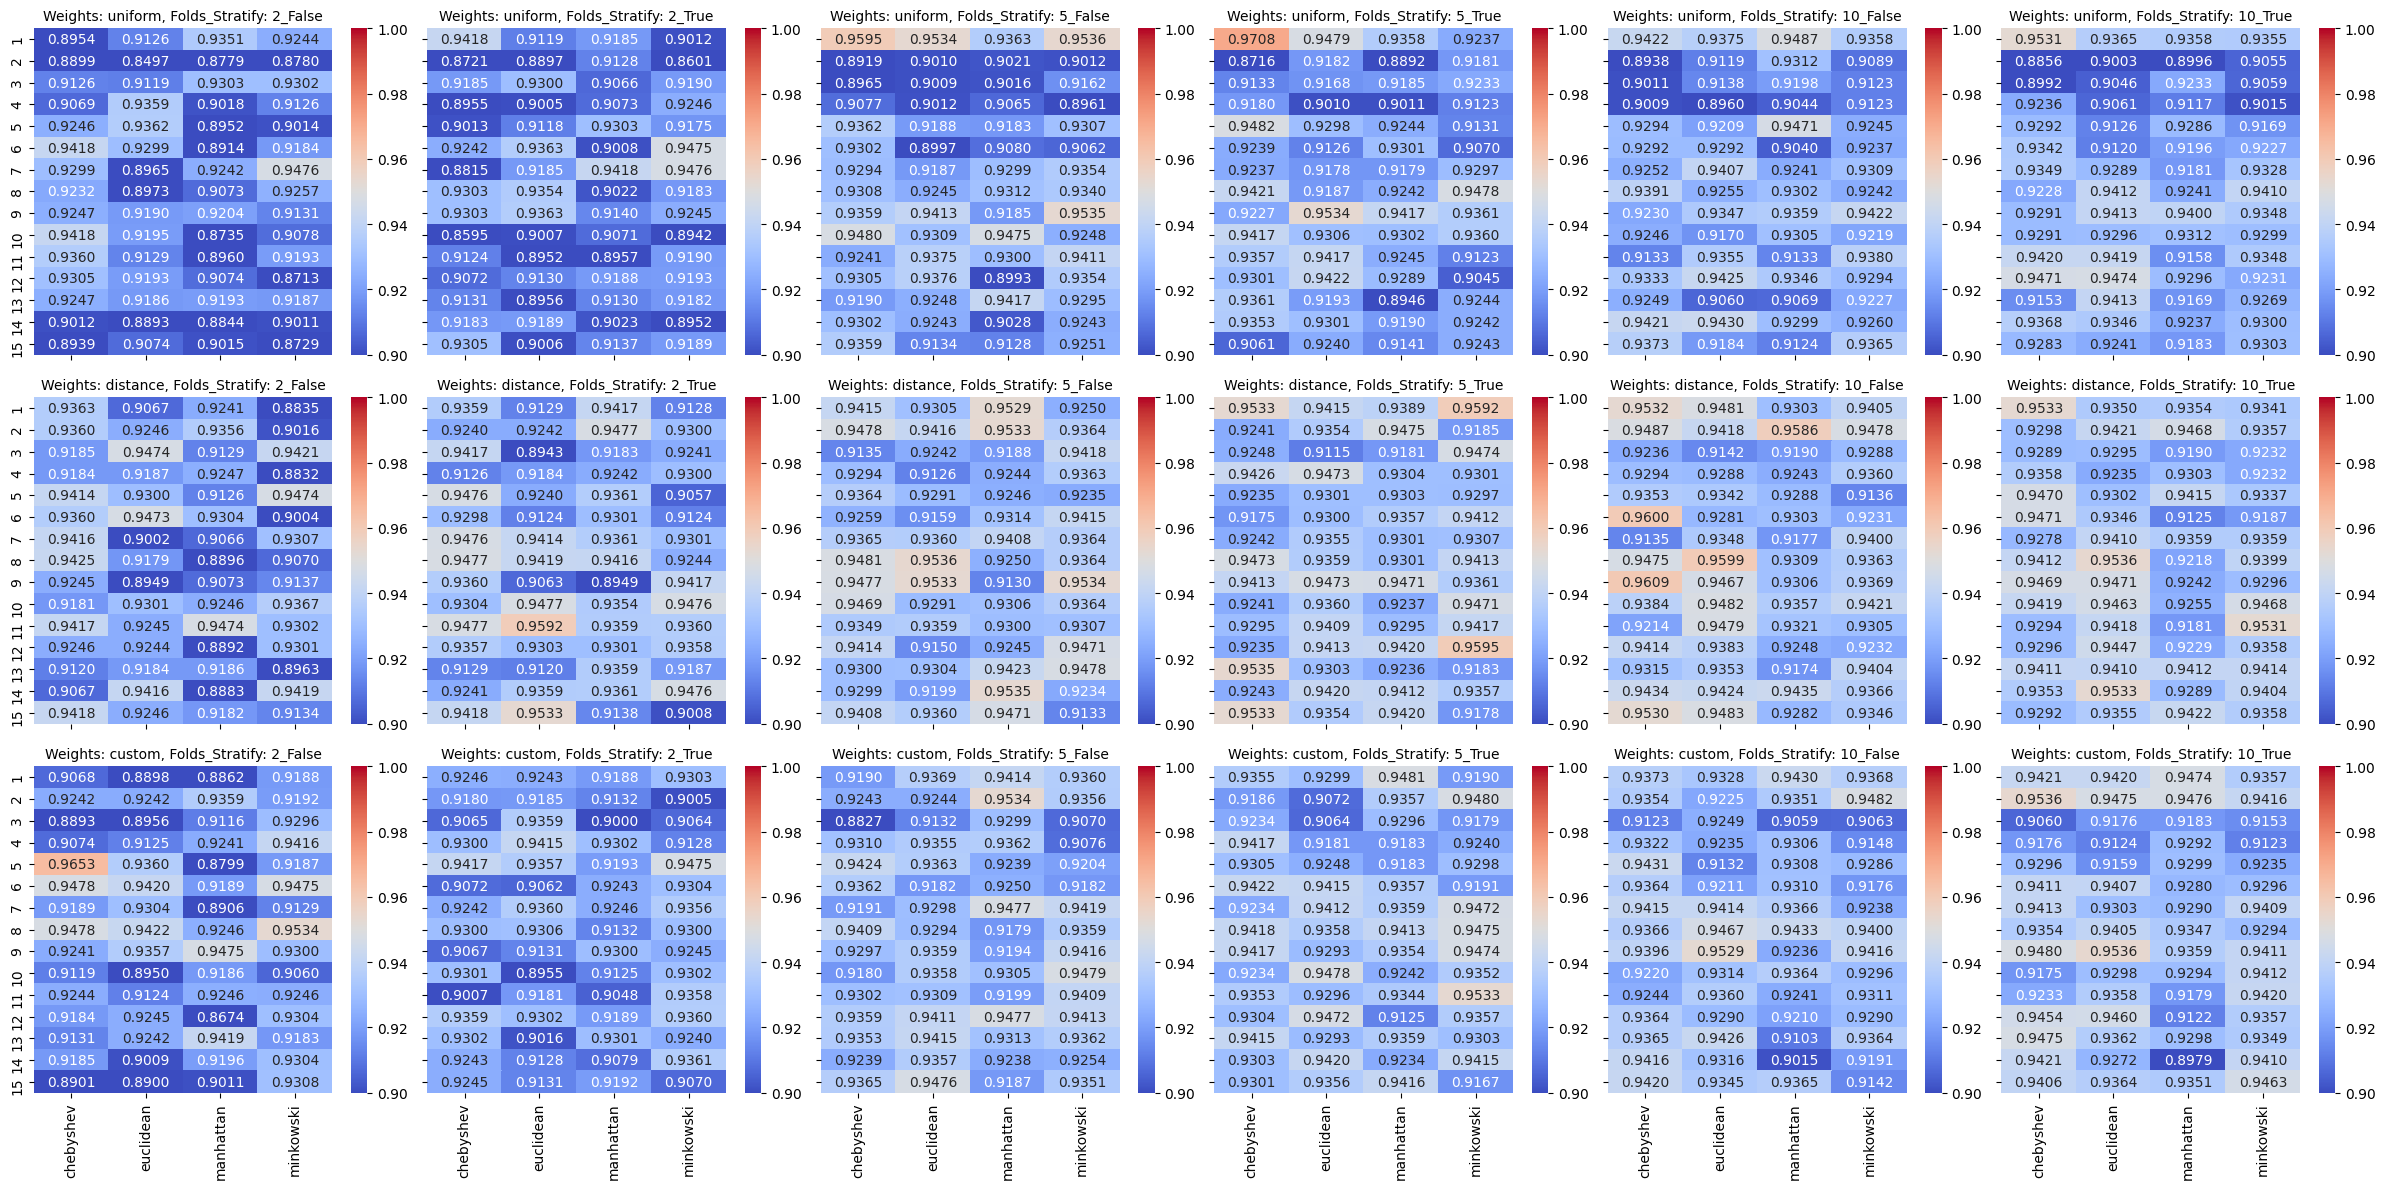

      K     Metric   Weights  Folds  Stratify     Score Folds_Stratify
39    1  chebyshev   uniform      5      True  0.970784         5_True
336   5  chebyshev    custom      2     False  0.965286        2_False
622   9  chebyshev  distance     10     False  0.960876       10_False
406   6  chebyshev  distance     10     False  0.959952       10_False
514   8  euclidean  distance     10     False  0.959864       10_False
855  12  minkowski  distance      5      True  0.959521         5_True
38    1  chebyshev   uniform      5     False  0.959501        5_False
727  11  euclidean  distance      2      True  0.959243         2_True
63    1  minkowski  distance      5      True  0.959228         5_True
100   2  manhattan  distance     10     False  0.958553       10_False
515   8  euclidean  distance     10      True  0.953623        10_True
56    1  minkowski   uniform      5     False  0.953605        5_False
512   8  euclidean  distance      5     False  0.953596        5_False
593   

In [14]:
results_df = full_test(Wine.get_dataFrame(), Wine.target_feature, pca_comp=4)

plot_results(results_df)

print(get_top_n_scores(results_df, 15))

W najlepszych wynikach przeważa sposób głosowania po dystansie.

Metodą pojawiającą się najcześciej w nalepszych wynikach miar odległości jest metoda Czebyszewa a najgorszą jest metoda Manhatan`a

PCB

In [11]:
class Pcb:
    target_feature = "class (0,1)"

    def get_dataFrame(year: int = 1) -> pd.DataFrame:
        data = pd.read_csv(
            f"{year}year.csv",
            names=[
                "net profit / total assets",
                "total liabilities / total assets",
                "working capital / total assets",
                "current assets / short-term liabilitiesl",
                "[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365",
                "retained earnings / total assets",
                "EBIT / total assets",
                "book value of equity / total liabilities",
                "sales / total assets",
                "equity / total assets",
                "(gross profit + extraordinary items + financial expenses) / total assets",
                "gross profit / short-term liabilities",
                "(gross profit + depreciation) / sales",
                "(gross profit + interest) / total assets",
                "(total liabilities * 365) / (gross profit + depreciation)",
                "(gross profit + depreciation) / total liabilities",
                "total assets / total liabilities",
                "gross profit / total assets",
                "gross profit / sales",
                "(inventory * 365) / sales",
                "sales (n) / sales (n-1)",
                "profit on operating activities / total assets",
                "net profit / sales",
                "gross profit (in 3 years) / total assets",
                "(equity - share capital) / total assets",
                "(net profit + depreciation) / total liabilities",
                "profit on operating activities / financial expenses",
                "working capital / fixed assets",
                "logarithm of total assets",
                "(total liabilities - cash) / sales",
                "(gross profit + interest) / sales",
                "(current liabilities * 365) / cost of products sold",
                "operating expenses / short-term liabilities",
                "operating expenses / total liabilities",
                "profit on sales / total assets",
                "total sales / total assets",
                "(current assets - inventories) / long-term liabilities",
                "constant capital / total assets",
                "profit on sales / sales",
                "(current assets - inventory - receivables) / short-term liabilities",
                "total liabilities / ((profit on operating activities + depreciation) * (12/365))",
                "profit on operating activities / sales",
                "rotation receivables + inventory turnover in days",
                "(receivables * 365) / sales",
                "net profit / inventory",
                "(current assets - inventory) / short-term liabilities",
                "(inventory * 365) / cost of products sold",
                "EBITDA (profit on operating activities - depreciation) / total assets",
                "EBITDA (profit on operating activities - depreciation) / sales",
                "current assets / total liabilities",
                "short-term liabilities / total assets",
                "(short-term liabilities * 365) / cost of products sold)",
                "equity / fixed assets",
                "constant capital / fixed assets",
                "working capita",
                "(sales - cost of products sold) / sales",
                "(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)",
                "total costs /total sales",
                "long-term liabilities / equity",
                "sales / inventory",
                "sales / receivables",
                "(short-term liabilities *365) / sales",
                "sales / short-term liabilities",
                "sales / fixed assets",
                Pcb.target_feature,
            ],
        )

        return data

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1781
           1       0.00      0.00      0.00        71

    accuracy                           0.96      1852
   macro avg       0.48      0.50      0.49      1852
weighted avg       0.92      0.96      0.94      1852



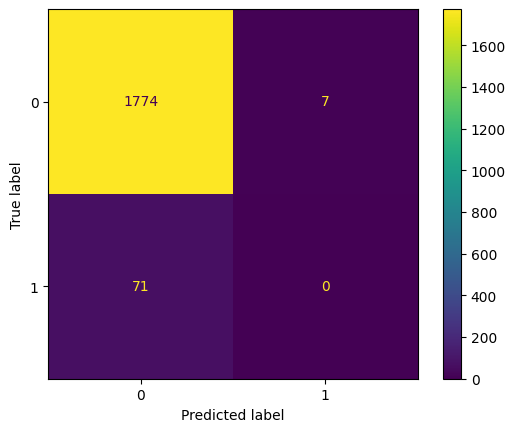

Normal F1: 0.9410
2-fold non_stratify cross-validation: F1-score = 0.9426
5-fold non_stratify cross-validation: F1-score = 0.9422
10-fold non_stratify cross-validation: F1-score = 0.9421


0.9421312957523558

In [12]:
cm, accuracy, precision, recall, f_score = Compute_scores(
    Pcb.get_dataFrame(), Pcb.target_feature, pca_comp=4
)

print(f"Normal F1: {f_score:.4f}")
cross_validation_scores(
    Pcb.get_dataFrame(), Pcb.target_feature, pca_comp=4, folds=2, print_result=True
)
cross_validation_scores(
    Pcb.get_dataFrame(), Pcb.target_feature, pca_comp=4, folds=5, print_result=True
)
cross_validation_scores(
    Pcb.get_dataFrame(), Pcb.target_feature, pca_comp=4, folds=10, print_result=True
)

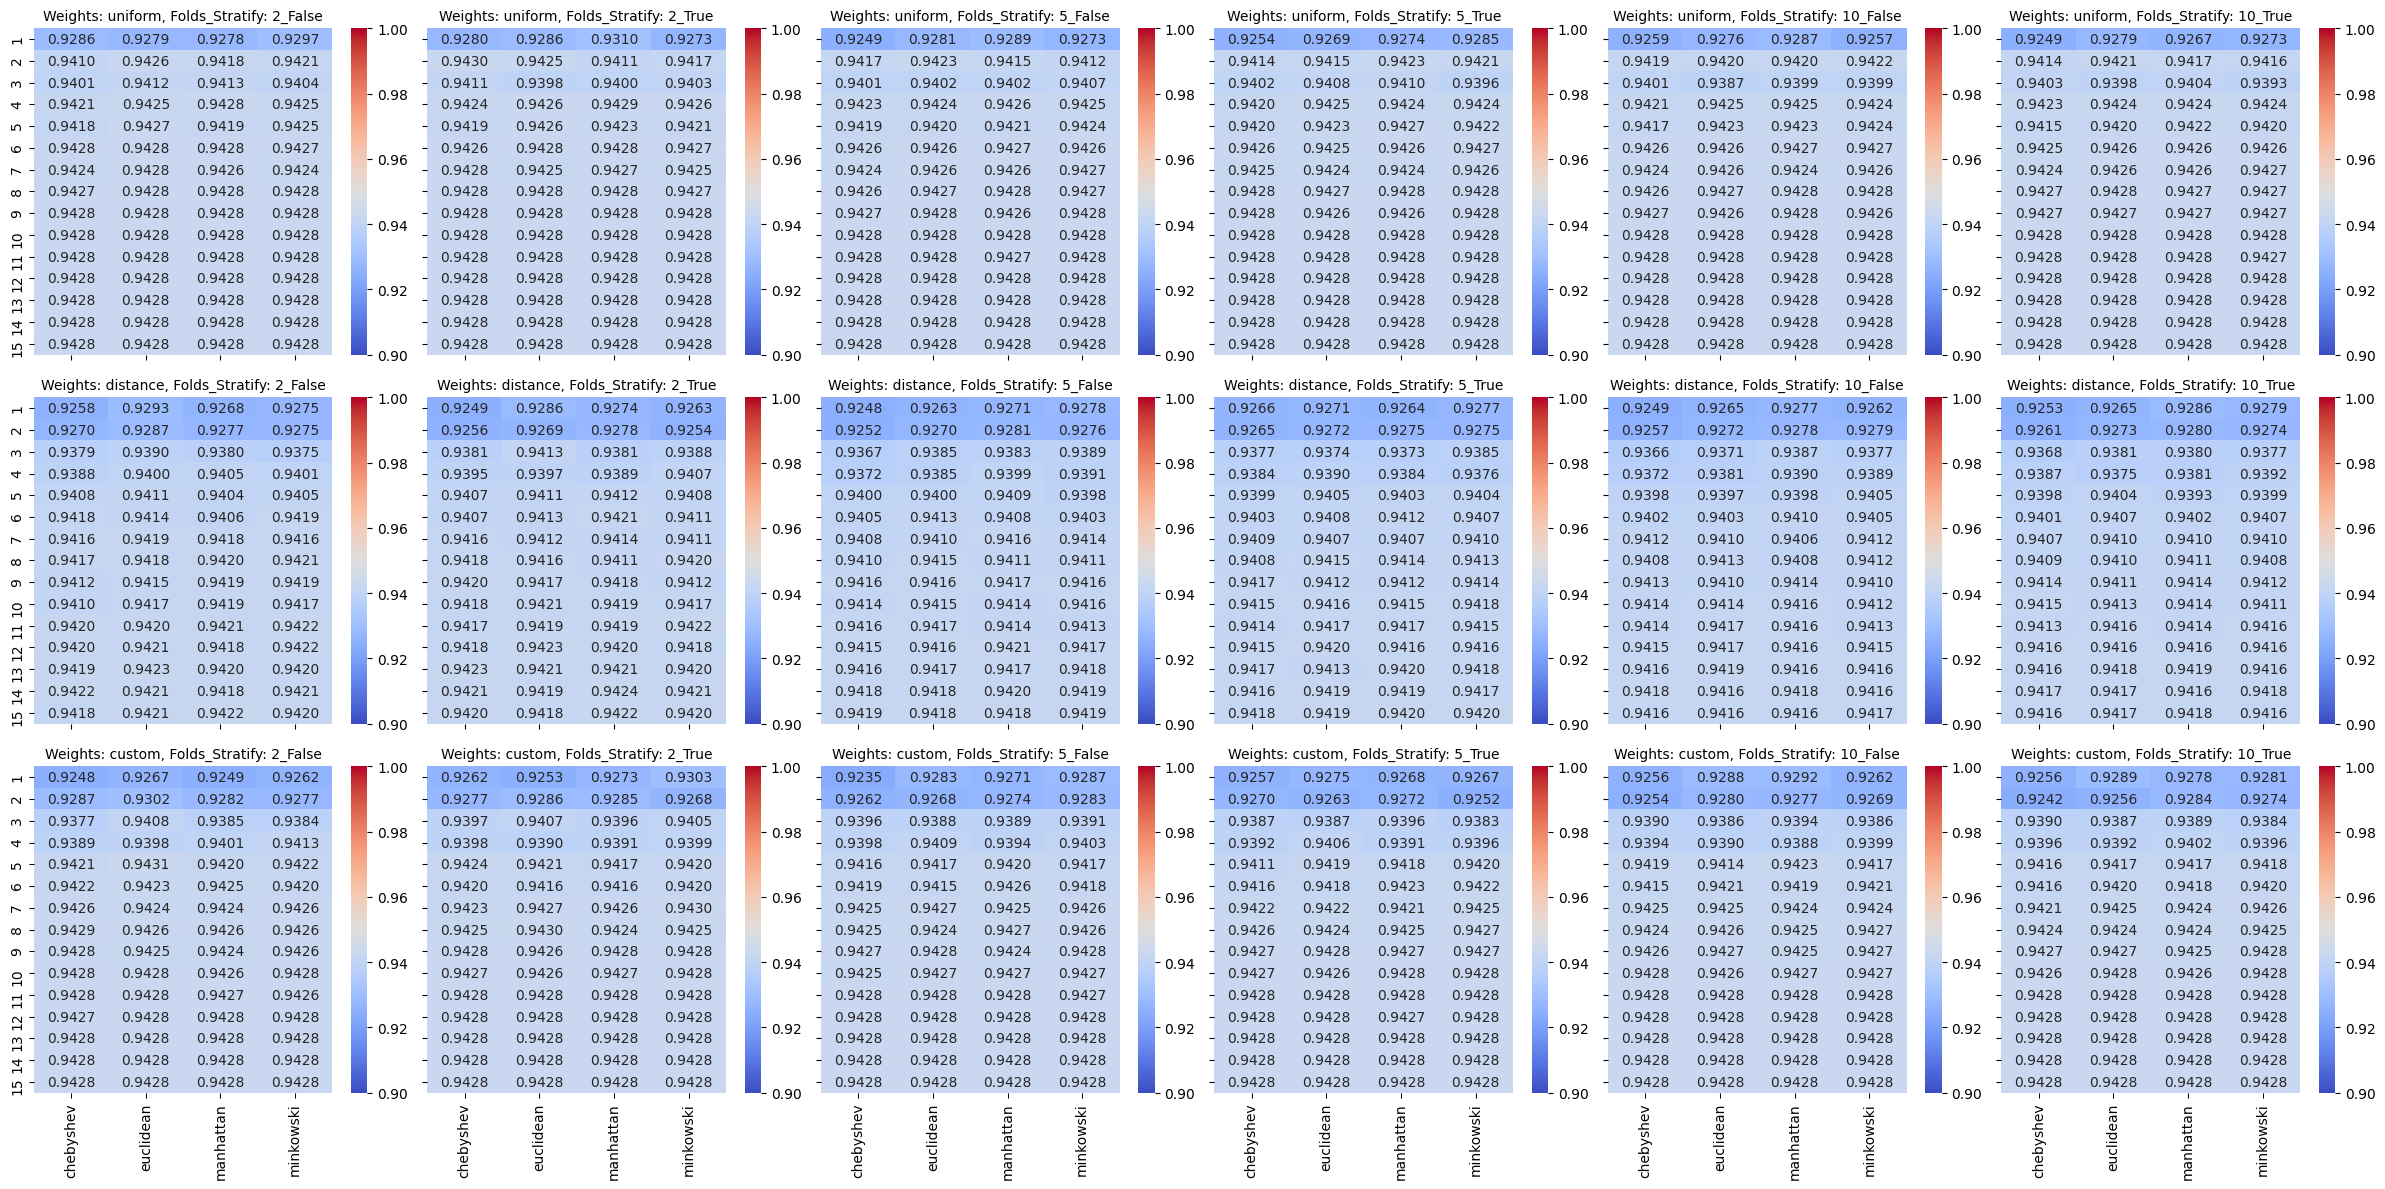

     K     Metric  Weights  Folds  Stratify     Score Folds_Stratify
300  5  euclidean   custom      2     False  0.943141        2_False
517  8  euclidean   custom      2      True  0.943002         2_True
499  7  minkowski   custom      2      True  0.943002         2_True
109  2  chebyshev  uniform      2      True  0.942973         2_True
552  8  chebyshev   custom      2     False  0.942924        2_False


In [15]:
results_df = full_test(Pcb.get_dataFrame(), Pcb.target_feature, pca_comp=4)

plot_results(results_df)

print(get_top_n_scores(results_df, 5))

Wyniki są do siebie na tyle podobne ,że gdyby pokazywać tylko 2 miejsca po przecinku ciężko by było stwiedzić jakiekolwiek różnice.

Największy wpłym na wyniki miał parametr K_neighbours który minimalnie musi być ustawiony na 3.

PYTANIA GŁÓWNE

1. Jak wpływa na wyniki klasyfikatora k-nn dla zbioru IRIS. Jak liczba foldów wpływa na skuteczność?\
   Ustawienie k-nn od 3 do 6 owocuje najlepszymi wynikami. Ilośc foldów w top 15 wyników to przeważnie 10, 15 ale przy innych parametrach również pojawiły się 2 ale małej ilości. 


2. Warto także zwrócić uwagę czy parzysta i nieparzysta liczba sąsiadów daje podobne wyniki? Dlaczego\
    powyżej przeprowadzonych badaniach nie zaobserwowałem znaczącej różnicy pomiędzy parzystą, a nieparzystą ilością sąsiadów. W teorii nieparzysta ilość sąsiadów powinna być lepsze, gdyż nie ma możliwości powstania przy głosowaniu uniform remisów pomiędzy dwoma klasami, co może się wydarzyć dla parzystej ilości.

3. Czy zmienia się skuteczność klasyfikacji k-nn dla badanych zbiorów jeśli zastosowana zostanie walidacja stratyfikowana? Dlaczego?
    W moich wynikach wychodzi że nie ma to za bardzo znaczenia jeśli patrzymy na wsyzstkie wyniki. Dla wybranych hiperparametrów ma to natomaist zanczenie ponieważ wyniki w takim przypadku mogą sięznaczenie różnić\
    na przykład (0.93 vs 0.95). Ale ze względu na to żę dla innych hiper parametrów będzie to (0.95 vs 0.93) to można uznać że nie ma to znaczenia.

4. Przy realizacji zadania należy rozważyć: czy dane powinny być powtórzone? Czy uśredniać wyniki dla miar, foldów?\
    Z moich obserwacji wynika że wyniki są podbne lub takie same bez względu na to ile razy się odtwarzało badania.

PYTANIA POMOCNICZE

1. Co jest modelem klasyfikacji w tym zadaniu? Dlaczego k-nn jest typu lazy learning?\
W tym zadaniu klasyfikacja nowej próbki jest dokonywana na podstawie szukania najbardziej podobnych do niej próbek (sąsiadów) ze zbioru treningowego. Na podstawie odległości sąsiadów oraz ich klas predykowana jest klasa nowej próbki. K-nn jest typu lazy-learning, gdyż nie wymaga żadnego wcześniejszego uczenia - model zapamiętuje tylko próbki jakie otrzymał w zbiorze treningowym i tylko w ramach inferencji dokonuje obliczeń.

2. Ile parametrów ma klasyfikator k-nn? Które z nich są istotne dla skuteczności? \
 Klasyfikator k-nn ma 3 różne parametry: ilość sąsiadów, sposób głosowania oraz funkcję odległości. Wszystkie trzy parametry są istotne dla skuteczności, natomiast jak mocno, który polepsza skuteczność modelu jest zależne od zbioru danych.

3.  Czym się różni kroswalidacja stratyfikowana od „zwykłej”? \
Podział stratyfikowany polega na podzieleniu zbioru na podzbiory w taki sposób aby wszystkie klasy były równo reprezentowane w każdym z podzbiorów.


4. Dlaczego zwykle nie stosujemy walidacji krzyżowej leave-one-out?\
Walidacja krzyżowa leave-one-out polega na wykonaniu tylu splitów w walidacji krzyżowej ile jest elementów w zbiorze danych - dla każdego splitu mamy jeden element w zbiorze walidacyjnym. Z reguły nie stosuje się takiej techniki, gdyż jest ona bardzo czaso i zasobo-żerna oraz nie oferuje z praktycznego punktu widzenia lepszej ewaluacji niż np. 2 elementy w zbiorze walidacyjnym per split.

5. Czy k-nn wymaga standaryzacji/normalizacji danych? \
   K-nn wymaga standaryzacji/normalizacjia danych ze względu na to, że model jest oparty na liczeniu odległości pomiędzy próbkami. Gdy cechy mają różne dziedziny, model będzie bardziej zbiasowany w kierunku matchowania tej konkretnej cechy co nie ma żadnego uzasadnienia z formalnego punktu widzenia - wszystkie cechy powinniśmy uważać za równe chyba, że chcemy umieścić w modelowaniu jakąś wiedzę dziedzinową a priori.

6. Dlaczego miara Accuracy dla zbiorów niezbalansowanych jest mniej użyteczna niż miara F-score? \
   Miara accuracy jest gorszym wyborem niż F-score, gdyż bada ona tylko ilość poprawnie zaklasyfikowanych próbek co sprawia, że klasy słabiej reprezentowane mają mniejszy wpływ na wartość accuracy - poprawność klasyfikacji na klasie z większą ilością reprezentantów dominuje wartość metryki.